In [1]:
# Cell 1: Imports and Config
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# === Add project root to sys.path ===
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]  # if running as script
except NameError:
    PROJECT_ROOT = Path().resolve().parents[0]  # if running in notebook

sys.path.append(str(PROJECT_ROOT))

# === Imports from src ===
from src.qnn_model import QNNClassifier, Config
from src.data_loader import get_mnist_dataset

# === Config ===
cfg = Config()
REPORTS_DIR = PROJECT_ROOT / "reports"
DATASET_DIR = PROJECT_ROOT / "datasets"
MODEL_PATH = REPORTS_DIR / "qnn_trained_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")


🔧 Using device: cuda


In [2]:
# Cell 2: Load test data (same preprocessing as train)
images, labels = get_mnist_dataset(
    data_dir=DATASET_DIR,
    binary_digits=tuple(range(10)),
    image_size=(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
    train=False,
    download=True,
    limit_samples=cfg.LIMIT_SAMPLES
)

X_test = images.to(device).to(torch.float64)
y_test = labels.to(device)
print(f"✅ Loaded test set: {X_test.shape}")


✅ Loaded test set: torch.Size([1000, 1, 28, 28])


In [3]:
# Cell 3: Load the trained model
model = QNNClassifier(cfg.NUM_QUBITS, cfg.NUM_CLASSES, cfg.NUM_LAYERS).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print(f"✅ Loaded model from: {MODEL_PATH}")


✅ Loaded model from: D:\QNN_Robustness_Project\reports\qnn_trained_model.pt


C:\Users\Harsh\AppData\Local\Temp\ipykernel_368\1172377170.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=devi

In [4]:
# Cell 4: Run predictions
with torch.no_grad():
    logits = model(X_test)
    predictions = torch.argmax(logits, dim=1)

print("✅ Predictions complete.")


✅ Predictions complete.


In [5]:
# Cell 5: Evaluate metrics
acc = accuracy_score(y_test.cpu(), predictions.cpu())
print(f"🎯 Accuracy: {acc * 100:.2f}%")

# Print full classification report
print("\n[INFO] Classification Report:\n")
print(classification_report(y_test.cpu(), predictions.cpu(), digits=4))


🎯 Accuracy: 82.90%

[INFO] Classification Report:

              precision    recall  f1-score   support

           0     0.8667    0.9176    0.8914        85
           1     0.9603    0.9603    0.9603       126
           2     0.8000    0.8966    0.8455       116
           3     0.8780    0.6729    0.7619       107
           4     0.9082    0.8091    0.8558       110
           5     0.6449    0.7931    0.7113        87
           6     0.8556    0.8851    0.8701        87
           7     0.8351    0.8182    0.8265        99
           8     0.8525    0.5843    0.6933        89
           9     0.7227    0.9149    0.8075        94

    accuracy                         0.8290      1000
   macro avg     0.8324    0.8252    0.8224      1000
weighted avg     0.8383    0.8290    0.8275      1000



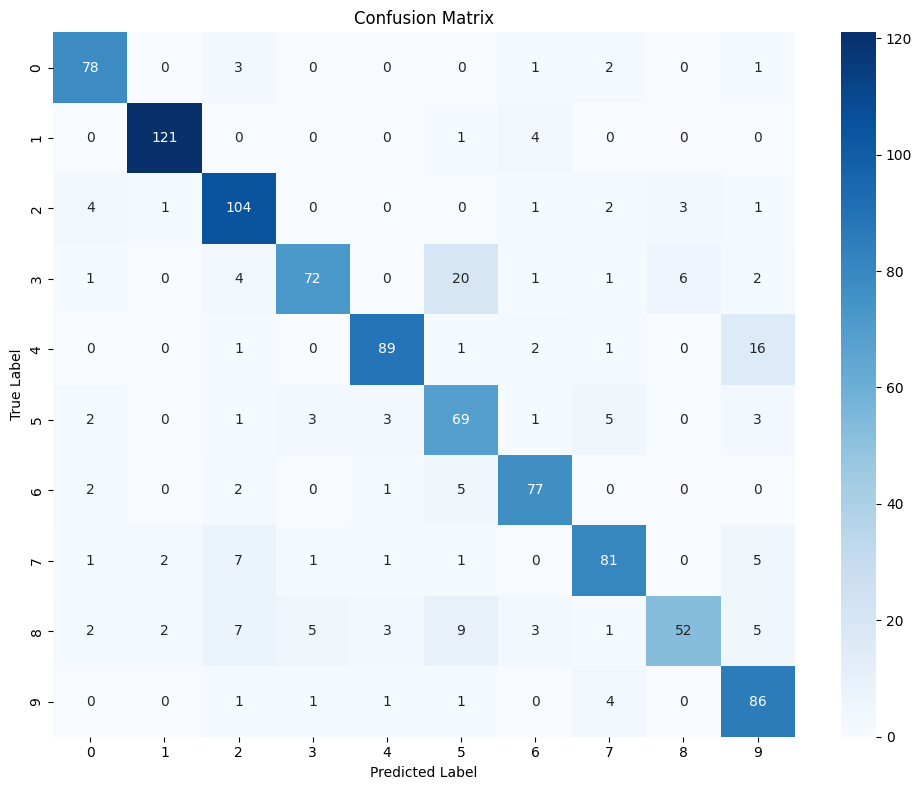

In [6]:
# Cell 6: Plot confusion matrix
cm = confusion_matrix(y_test.cpu(), predictions.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(REPORTS_DIR / "confusion_matrix.png")
plt.show()


In [7]:
# Cell 7: Save report
report = classification_report(
    y_test.cpu(), predictions.cpu(),
    digits=4, output_dict=True
)

import json
with open(REPORTS_DIR / "classification_report.json", "w") as f:
    json.dump(report, f, indent=4)

print(f"📁 Metrics saved to: {REPORTS_DIR}")


📁 Metrics saved to: D:\QNN_Robustness_Project\reports


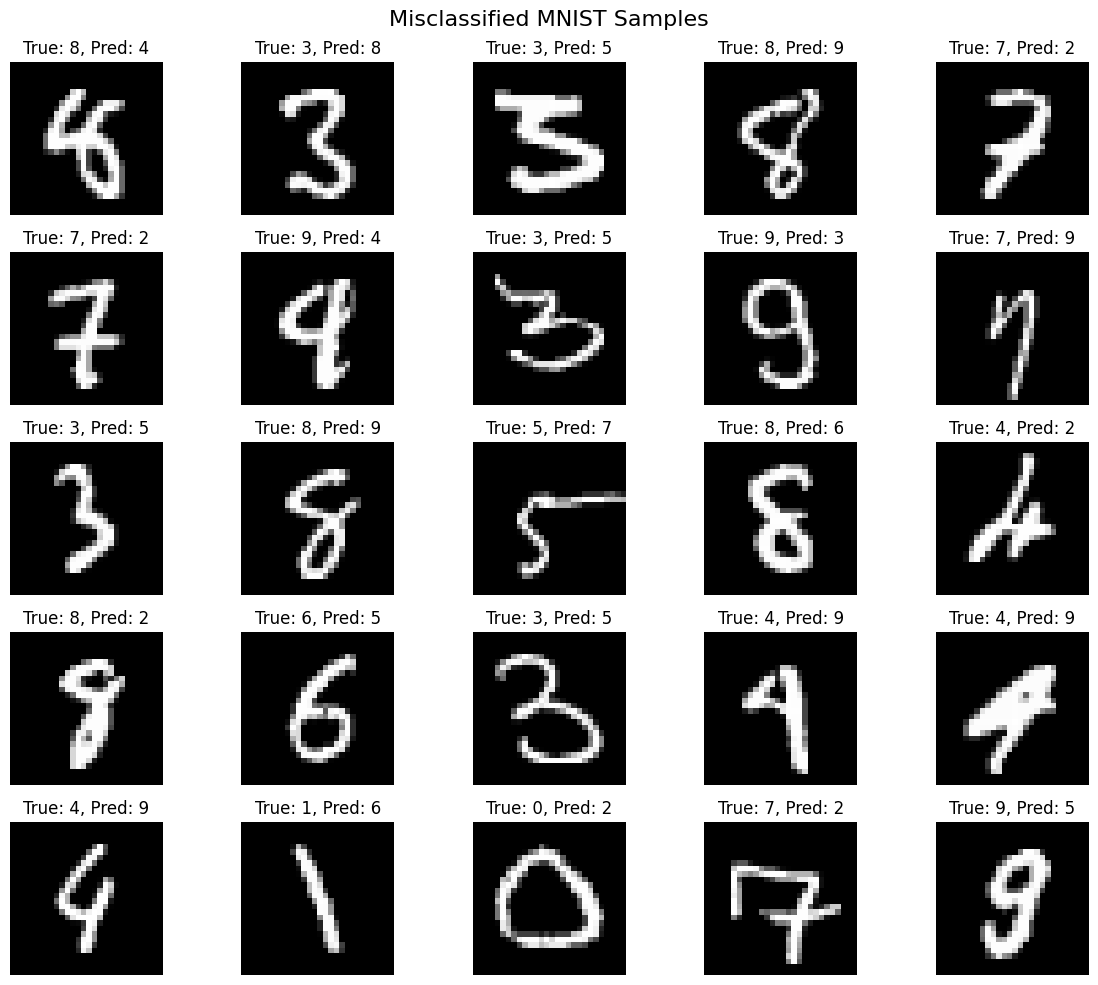

In [8]:
# Identify misclassified indices
misclassified_idxs = (predictions != y_test).nonzero(as_tuple=True)[0]

# Show up to 25 misclassified examples
num_images = min(25, len(misclassified_idxs))
fig, axes = plt.subplots(5, 5, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    if i >= num_images:
        break
    idx = misclassified_idxs[i].item()
    image = X_test[idx].cpu().squeeze()
    actual = y_test[idx].item()
    pred = predictions[idx].item()

    ax.imshow(image, cmap="gray")
    ax.set_title(f"True: {actual}, Pred: {pred}")
    ax.axis("off")

plt.suptitle("Misclassified MNIST Samples", fontsize=16)
plt.tight_layout()
plt.savefig(REPORTS_DIR / "plots" / "misclassified_samples.png")
plt.show()


In [10]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test.cpu(), predictions.cpu())
print(f"Cohen's Kappa Score: {kappa:.4f}")


Cohen's Kappa Score: 0.8097


In [11]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test.cpu(), predictions.cpu())
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.8109


In [12]:
from sklearn.metrics import roc_auc_score
from torch.nn.functional import softmax

probs = softmax(logits, dim=1).cpu().numpy()
y_true_onehot = torch.nn.functional.one_hot(y_test, num_classes=cfg.NUM_CLASSES).cpu().numpy()

auc = roc_auc_score(y_true_onehot, probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {auc:.4f}")


ROC AUC Score (OvR): 0.9735


In [13]:
from sklearn.metrics import log_loss
test_log_loss = log_loss(y_test.cpu(), probs)
print(f"Log Loss: {test_log_loss:.4f}")


Log Loss: 0.6557


In [14]:
from sklearn.metrics import recall_score

# Sensitivity = recall (True Positive Rate)
sensitivity = recall_score(y_test.cpu(), predictions.cpu(), average=None)

# Specificity = TN / (TN + FP) for each class
cm = confusion_matrix(y_test.cpu(), predictions.cpu())
specificity = []

for i in range(cfg.NUM_CLASSES):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp + 1e-6))  # avoid divide-by-zero

for i in range(cfg.NUM_CLASSES):
    print(f"Class {i} - Sensitivity: {sensitivity[i]:.3f} | Specificity: {specificity[i]:.3f}")


Class 0 - Sensitivity: 0.918 | Specificity: 0.987
Class 1 - Sensitivity: 0.960 | Specificity: 0.994
Class 2 - Sensitivity: 0.897 | Specificity: 0.971
Class 3 - Sensitivity: 0.673 | Specificity: 0.989
Class 4 - Sensitivity: 0.809 | Specificity: 0.990
Class 5 - Sensitivity: 0.793 | Specificity: 0.958
Class 6 - Sensitivity: 0.885 | Specificity: 0.986
Class 7 - Sensitivity: 0.818 | Specificity: 0.982
Class 8 - Sensitivity: 0.584 | Specificity: 0.990
Class 9 - Sensitivity: 0.915 | Specificity: 0.964


In [16]:
topk = 3
top3_correct = torch.topk(logits, topk, dim=1).indices
correct_top3 = sum([y_test[i] in top3_correct[i] for i in range(len(y_test))])
top3_acc = correct_top3 / len(y_test) * 100
print(f"🎯 Top-{topk} Accuracy: {top3_acc:.2f}%")


🎯 Top-3 Accuracy: 93.40%


In [17]:
import json

metrics = {
    "accuracy": accuracy_score(y_test.cpu(), predictions.cpu()),
    "cohen_kappa": kappa,
    "matthews_corrcoef": mcc,
    "top3_accuracy": top3_acc,
    "roc_auc_score": auc,
    "log_loss": test_log_loss
}

with open(REPORTS_DIR / "metrics" / "evaluation_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)
